In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
from scipy.stats import kendalltau, t as tdist, chi2, norm
import os
from statsmodels.distributions.copula.api import (
    GumbelCopula, ClaytonCopula, StudentTCopula
)


df_p = pd.read_excel('../data/raw/datos_crudos.xlsx')
df = pd.read_csv('../data/clean/datos_limpios.csv')

df['latitud'] = df['latitud'].astype(str).str.replace(",", "", regex=False)
df['longitud'] = df['longitud'].astype(str).str.replace(",", "", regex=False)

df['latitud'] = pd.to_numeric(df['latitud'], errors="coerce")
df['longitud'] = pd.to_numeric(df['longitud'], errors="coerce")


In [2]:
def dataset_provincial(df):
    df = df.copy()
    df = df.dropna(subset=['provincia','total'])
    df['ano'] = df['ano'].astype(int)

    prov_year = (df.groupby(['ano','provincia'], as_index=False)
                   .agg(total_anual=('total','sum'),
                        eventos=('total','size'),
                        latitud=('latitud','first'),
                        longitud=('longitud','first')))

    prov_resumen = (prov_year.groupby('provincia', as_index=False)
                    .agg(severidad_media=('total_anual','mean'),
                         severidad_total=('total_anual','sum'),
                         frecuencia_media=('eventos','mean'),
                         latitud=('latitud','first'),
                         longitud=('longitud','first')))
    prov_resumen['risk_score'] = prov_resumen['severidad_media'] * prov_resumen['frecuencia_media']

    cat_prov_count = (df.groupby(['categoria','provincia'])['total']
                        .size().unstack(fill_value=0))
    cat_prov_sum   = (df.groupby(['categoria','provincia'])['total']
                        .sum().unstack(fill_value=0))

    return prov_year, prov_resumen, cat_prov_count, cat_prov_sum

def dataset_latlon(df):
    df = df.dropna(subset=['latitud','longitud'])

    geo_year = (df.groupby(['ano','latitud','longitud'], as_index=False)
                  .agg(total_anual=('total','sum'),
                       eventos=('total','size')))

    geo_total = (df.groupby(['latitud','longitud'], as_index=False)
                   .agg(severidad_media=('total','mean'),
                        severidad_total=('total','sum'),
                        frecuencia_anual=('total','size')))
    
    geo_total['risk_score'] = geo_total['severidad_media'] * geo_total['frecuencia_anual']

    return geo_year, geo_total


prov_year, prov_resumen, cat_prov_count, cat_prov_sum = dataset_provincial(df)
geo_year, geo_total = dataset_latlon(df)


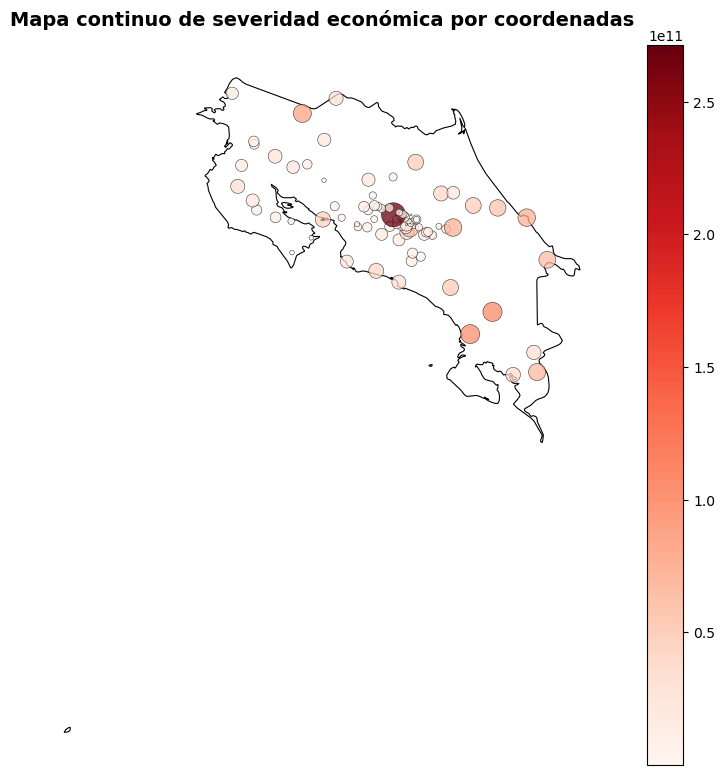

In [3]:
def mapa_puntos_severidad(geo_total, ruta_geo):
    costa = gpd.read_file(ruta_geo)

    gdf_points = gpd.GeoDataFrame(
        geo_total,
        geometry=gpd.points_from_xy(geo_total['longitud'], geo_total['latitud']),
        crs="EPSG:4326"
    )

    tam = np.sqrt(gdf_points['severidad_total'] / gdf_points['severidad_total'].max()) * 300

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(left=0.15, right=0.98, top=0.92, bottom=0.02)

    costa.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)

    gdf_points.plot(
        ax=ax,
        column='severidad_total',
        cmap='Reds',
        markersize=tam,
        legend=True,
        alpha=0.75,
        edgecolor='k',
        linewidth=0.4
    )

    ax.set_title("Mapa continuo de severidad económica por coordenadas",
                 fontsize=14, fontweight='bold', pad=14)

    ax.set_axis_off()

    leg = ax.get_legend()
    if leg:
        leg.set_bbox_to_anchor((1.22, 0.5))
        leg._loc = 6

    plt.show()

mapa_puntos_severidad(geo_total, '../data/cr.json')

In [5]:
def mapa_severidad_provincia(prov_resumen, ruta_geo, col_valor='severidad_media'):
    gdf = gpd.read_file(ruta_geo)

    gdf['name'] = gdf['name'].str.upper()
    prov_resumen['provincia'] = prov_resumen['provincia'].str.upper()

    mapa = gdf.merge(
        prov_resumen[['provincia', col_valor]],
        left_on='name',
        right_on='provincia',
        how='left'
    )

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(left=0.20, right=0.98, top=0.92, bottom=0.02)

    try:
        import mapclassify
        usar_scheme = True
    except ImportError:
        usar_scheme = False
        print("Aviso: mapclassify no está instalado. Se omitirá 'scheme=Quantiles'.")

    if usar_scheme:
        mapa.plot(
            column=col_valor,
            cmap='Reds',
            scheme='Quantiles', k=5,
            legend=True,
            edgecolor='black',
            ax=ax
        )
    else:
        mapa.plot(
            column=col_valor,
            cmap='Reds',
            legend=True,
            edgecolor='black',
            ax=ax
        )

    ax.set_title(f"Severidad económica por provincia ({col_valor})",
                 fontsize=14, fontweight='bold')

    ax.set_axis_off()

    leg = ax.get_legend()
    if leg:
        leg.set_bbox_to_anchor((-0.05, 0.5)) 
        leg._loc = 6

    plt.show()

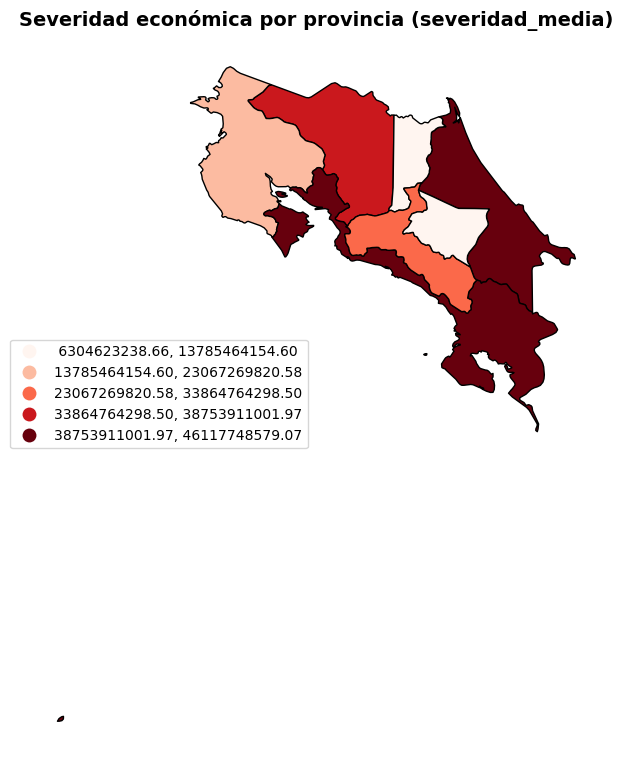

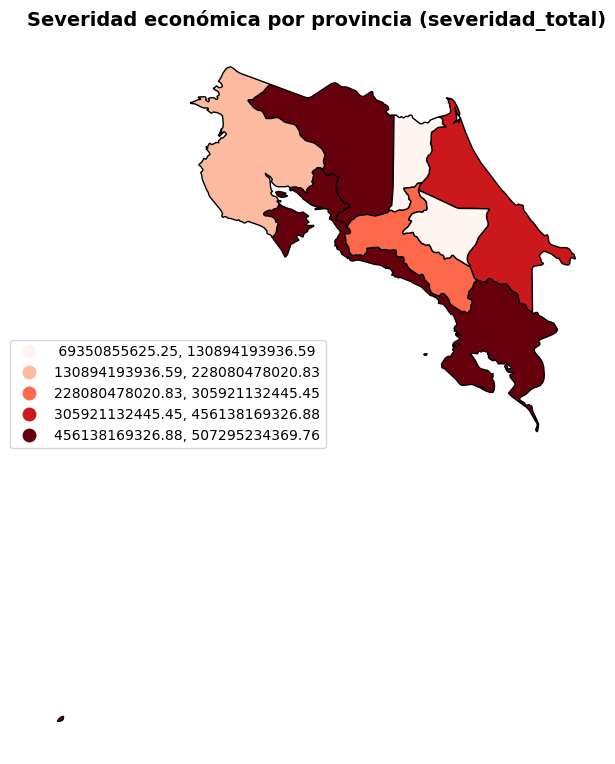

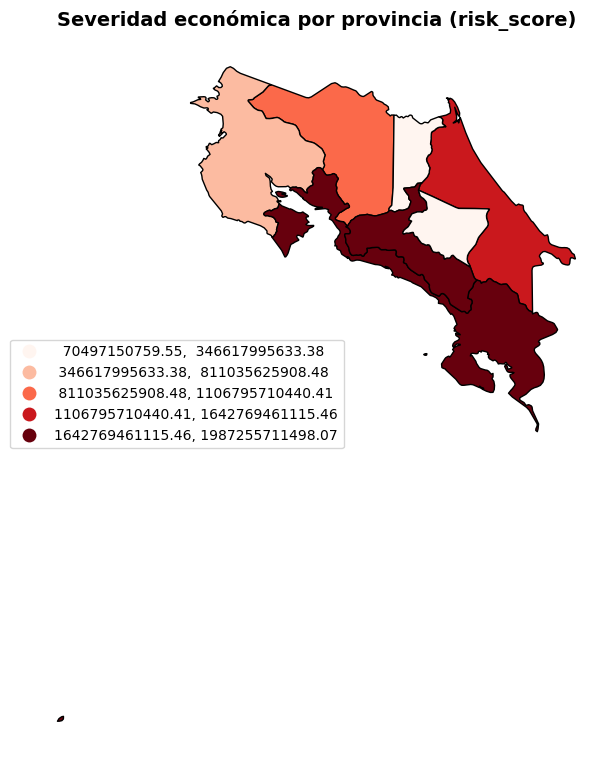

In [41]:
mapa_severidad_provincia(prov_resumen, '../data/provincias.json', col_valor='severidad_media')
mapa_severidad_provincia(prov_resumen, '../data/provincias.json', col_valor='severidad_total')
mapa_severidad_provincia(prov_resumen, '../data/provincias.json', col_valor='risk_score')

In [55]:
df['provincia'][1].upper()

'CARTAGO'

In [ ]:
def max_anual_por_provincia(df, categoria=None, col_total='total'):
    d = df.copy()
    if categoria is not None:
        d = d[d['categoria'].eq(categoria)]
    mx = (d.groupby(['ano','provincia'], as_index=False)
            .agg(max_total=(col_total,'max')))
    piv = mx.pivot(index='ano', columns='provincia', values='max_total').sort_index()
    return piv

def ecdf_value(x, sample):
    if len(sample) == 0 or np.all(pd.isna(sample)):
        return np.nan
    s = np.sort(np.asarray(sample)[~pd.isna(sample)])
    r = np.searchsorted(s, x, side='right')
    return (r + 1.0) / (len(s) + 2.0)

def cargar_tail_params_provincia(
    nombre_provincia: str,
    carpeta: str = '../res/provincias'
) -> dict:
    prov = nombre_provincia.upper().replace(" ", "_")
    base_filename = f"tail_{prov}.csv"

    ruta = os.path.join(carpeta, base_filename)
    if not os.path.exists(ruta):
        raise FileNotFoundError(f"No se encontró: {ruta}")

    dfp = pd.read_csv(ruta)
    if dfp.empty:
        raise ValueError(f"CSV vacío: {ruta}")

    mname = str(dfp.loc[0, 'model_name']).strip()
    u     = float(dfp.loc[0, 'u_opt'])
    p_u   = float(dfp.loc[0, 'p_u'])
    location = str(dfp.loc[0, 'location']) if 'location' in dfp.columns else prov

    if mname.upper().startswith("KDE"):
        kernel = str(dfp.loc[0, 'kernel'])
        bw     = float(dfp.loc[0, 'bandwidth'])
        x_grid = dfp['x'].to_numpy()
        dens   = dfp['f'].to_numpy()
        return {
            'tipo': 'KDE',
            'model': mname,
            'u': u,
            'p_u': p_u,
            'params': (kernel, bw),
            'x_grid': x_grid,
            'dens': dens,
            'location': location
        }
    else:
        cols_params = [c for c in dfp.columns if c.lower().startswith(mname.lower() + '_param')]
        if not cols_params:
            cols_params = [c for c in dfp.columns if 'param' in c.lower()]
        cols_params = sorted(cols_params, key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
        params = tuple(float(dfp.loc[0, c]) for c in cols_params)
        return {
            'tipo': 'parametrico',
            'model': mname,
            'u': u,
            'p_u': p_u,
            'params': params,
            'location': location
        }



In [ ]:
def F_exc_gpd(y, sigma, xi):
    # y>0.  CDF de excesos: 1-exp(-y/sigma) si xi=0; 1-(1+xi y/sigma)^(-1/xi) si xi!=0
    if y <= 0:
        return 0.0
    if abs(xi) < 1e-12:
        return 1.0 - np.exp(-y / sigma)
    base = 1.0 + xi * y / sigma
    if base <= 0:
        # fuera del dominio si xi<0 y y superó el soporte
        return 1.0
    return 1.0 - base**(-1.0/xi)

def F_exc_pareto(y, xm, k):
    # Y ~ Pareto(xm,k) con soporte y>0; CDF = 1 - (xm/(xm+y))^k
    if y <= 0:
        return 0.0
    return 1.0 - (xm / (xm + y))**k

def F_exc_burr(y, c, k, lam):
    # Y ~ Burr XII(c,k,lam); CDF = 1 - (1 + (y/lam)^c)^(-k)
    if y <= 0:
        return 0.0
    return 1.0 - (1.0 + (y/lam)**c)**(-k)

def F_exc_lognormal(y, mu, sig):
    # Y ~ LogNormal(mu,sig). Requiere y>0.
    if y <= 0:
        return 0.0
    from scipy.stats import norm
    return norm.cdf((np.log(y) - mu) / sig)

def F_total_hibrida(
    x: float,
    body_sample: np.ndarray,
    u: float,
    p_u: float,
    model: str,
    params: tuple,
    tipo: str = 'parametrico',
    x_grid=None,
    dens=None,
    a: float = 1.0,
    b: float = 2.0
) -> float:
    if x <= u:
        return ecdf_value(x, body_sample, a=a, b=b)

    y = x - u
    m = model.lower()
    if tipo == 'kde':
        if x_grid is None or dens is None:
            return np.nan
        idx = np.searchsorted(x_grid, y, side='right')
        Fexc = dens[:idx].sum() / dens.sum() if idx > 0 else 0.0
    elif m == 'pareto_max':
        a, y0 = params
        Fexc = 1.0 - (y0 / x)**a if x >= y0 else 0.0
    elif m == 'gpd':
        sigma, xi = params
        Fexc = F_exc_gpd(y, sigma, xi)
    elif m == 'pareto':
        xm, k = params
        Fexc = F_exc_pareto(y, xm, k)
    elif m == 'burr':
        c, k, lam = params
        Fexc = F_exc_burr(y, c, k, lam)
    elif m in ('ln_tail', 'lognormal', 'lognormal_tail'):
        mu, sig = params
        Fexc = F_exc_lognormal(y, mu, sig)
    else:
        raise ValueError(f"Modelo de cola no soportado: {model}")
    return 1.0 - p_u * (1.0 - Fexc)


In [8]:
def construir_U_EVT(df, piv_max, carpeta_csv='csv_provincia', col_total='total'):

    U = pd.DataFrame(index=piv_max.index, columns=piv_max.columns, dtype=float)

    for prov in piv_max.columns:
        # datos históricos de esa provincia para la parte 'body'
        sample_body = df.loc[df['provincia'].eq(prov), col_total].values

        info = cargar_tail_params_provincia(prov, carpeta=carpeta_csv)
        model, u, p_u, params = info['model'], info['u'], info['p_u'], info['params']

        # transforma cada x anual a U=F(x)
        xs = piv_max[prov]
        U[prov] = xs.apply(lambda x: np.nan if pd.isna(x)
                           else F_total_hibrida(float(x), sample_body, u, p_u, model, params))

    # eliminar años con NaN en alguna provincia
    U = U.dropna()
    # seguridad: recortar numéricamente para evitar 0 o 1 exactos
    eps = 1e-6
    U = U.clip(eps, 1.0 - eps)
    return U

In [9]:
def heatmap_lambda(L: pd.DataFrame, titulo="λ (cola superior) — t-cópula"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    vmax = np.nanmax(L.values)
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = 1.0
    plt.figure(figsize=(8,6))
    sns.heatmap(L, annot=True, fmt=".2f", cmap="Reds", vmin=0, vmax=vmax)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()

In [10]:
def pivot_maximos(df, categoria_1='categoria', categoria_2='provincia', valor='total'):
    piv = (
        df.groupby([categoria_1, categoria_2], as_index=False)
          .agg(max_total=(valor, 'max'))
          .pivot(index=categoria_1, columns=categoria_2, values='max_total')
          .sort_index()
    )
    return piv


def pseudo_u_empirica(x: pd.Series) -> pd.Series:
    s = x.dropna().rank(method='average')
    return s / (len(s) + 1.0)


def lambda_t_from_rho(rho, nu):
    rho = float(np.clip(rho, -0.9999, 0.9999))
    z = np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return float(2.0 * t.cdf(-z, df=nu + 1.0))


def lambda_gumbel_from_tau(tau):
    if tau <= 0: return 0.0
    if tau >= 1: return 1.0
    theta = 1.0 / (1.0 - tau)
    return float(2.0 - 2.0**(1.0/theta))


def fit_pair_robusto(u1, u2):
    u1, u2 = np.asarray(u1, float), np.asarray(u2, float)
    m = np.isfinite(u1) & np.isfinite(u2)
    u1, u2 = u1[m], u2[m]
    n = len(u1)
    if n < 3:
        return np.nan, "insuficiente"

    if n >= 5:
        try:
            cop = StudentTCopula()
            R, nu = cop.fit_corr_param(np.column_stack([u1, u2]))
            lam = lambda_t_from_rho(R[0,1], nu)
            return lam, f"t (ν={nu:.1f})"
        except Exception:
            pass

    tau, _ = kendalltau(u1, u2)
    if not np.isfinite(tau):
        return 0.0, "independencia"

    lam_g = lambda_gumbel_from_tau(tau)
    if lam_g > 0:
        return lam_g, f"Gumbel (τ={tau:.2f})"

    rho = np.sin(np.pi * tau / 2.0)
    lam_t = lambda_t_from_rho(rho, nu=5)
    return lam_t, f"t (τ={tau:.2f}, ν=5)"


def lambda_matrix(U: pd.DataFrame):
    provs = U.columns.tolist()
    L = pd.DataFrame(np.nan, index=provs, columns=provs)
    F = pd.DataFrame("",      index=provs, columns=provs)

    for i, j in itertools.combinations(range(len(provs)), 2):
        p_i, p_j = provs[i], provs[j]
        lam, fam = fit_pair_robusto(U[p_i].values, U[p_j].values)
        L.loc[p_i, p_j] = L.loc[p_j, p_i] = lam
        F.loc[p_i, p_j] = F.loc[p_j, p_i] = fam

    np.fill_diagonal(L.values, np.nan)
    return L, F


def dependencia_extrema(df, categoria_1='categoria', categoria_2='provincia',
                        valor='total', plot=True):
    piv = pivot_maximos(df, categoria_1, categoria_2, valor)
    U = piv.apply(pseudo_u_empirica, axis=0).dropna()
    U = U.clip(1e-6, 1-1e-6)

    L, F = lambda_matrix(U)

    if plot:
        plt.figure(figsize=(7,6))
        sns.heatmap(L, annot=True, fmt=".2f", cmap="Reds", vmin=0, vmax=1)
        plt.title("Dependencia extrema (λ cola superior) entre provincias")
        plt.tight_layout()
        plt.show()

    return L, F, U

In [ ]:
piv = max_anual_por_provincia(df, categoria=None, col_total='total')
U_evt = construir_U_EVT(df, piv, carpeta_csv='../res/csv_provincias', col_total='total')
U_evt.head(), U_evt.shape

In [59]:
L_evt, F_evt = lambda_matrix(U_evt)

heatmap_lambda(L_evt, "Dependencia extrema — marginales EVT (λ cola superior)")

print(F_evt)



NameError: name 't' is not defined

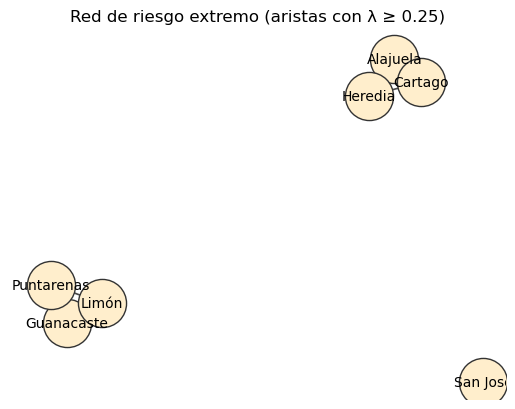

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def grafo_lambda(L: pd.DataFrame, umbral=0.25):
    G = nx.Graph()
    for i in L.index:
        G.add_node(i)
    for i in L.index:
        for j in L.columns:
            if i < j and np.isfinite(L.loc[i, j]) and L.loc[i, j] >= umbral:
                G.add_edge(i, j, weight=float(L.loc[i, j]))
    pos = nx.spring_layout(G, seed=42)
    w = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#ffeecc", edgecolors="#333")
    nx.draw_networkx_edges(G, pos, width=[3*wij for wij in w], alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(f"Red de riesgo extremo (aristas con λ ≥ {umbral:.2f})")
    plt.axis('off'); plt.show()

grafo_lambda(L_evt, umbral=0.25)



In [ ]:
# Simulación (usa las funciones que ya definiste: simular_perdida_total y resumen_riesgo)
loss, provincias = simular_perdida_total(
    df, N=50000, nu=5, carpeta_csv='csv_provincia', col_total='total'
)
res = resumen_riesgo(loss, alphas=(0.95, 0.99))
print(res)


NameError: name 'simular_perdida_total' is not defined

In [ ]:
loss, provincias = simular_perdida_total(df, N=50000, carpeta_csv='csv_provincia')
resumen_riesgo(loss)

NameError: name 'simular_perdida_total' is not defined

In [ ]:
U_inun = construir_U_EVT(df[df['categoria'].eq('INUNDACION')], piv, carpeta_csv='csv_provincia')
L_inun, _ = lambda_matrix(U_inun)
heatmap_lambda(L_inun, "Dependencia extrema — INUNDACIONES")


## Paquetes necesarios

In [44]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, t as tdist, chi2, norm
import os
from statsmodels.distributions.copula.api import (
    GumbelCopula, ClaytonCopula, StudentTCopula
)
import glob

## Resumenes de los datos

In [45]:
def dataset_provincial(df: pd.DataFrame):

    df = df.copy().dropna(subset=['provincia', 'total'])
    df['ano'] = df['ano'].astype(int)

    prov_year = (df.groupby(['ano', 'provincia'], as_index=False)
                   .agg(total_anual=('total', 'sum'),
                        eventos=('total', 'size'),
                        latitud=('latitud', 'first'),
                        longitud=('longitud', 'first')))

    prov_resumen = (prov_year.groupby('provincia', as_index=False)
                      .agg(severidad_media=('total_anual', 'mean'),
                           severidad_total=('total_anual', 'sum'),
                           frecuencia_media=('eventos', 'mean'),
                           latitud=('latitud', 'first'),
                           longitud=('longitud', 'first')))

    prov_resumen['risk_score'] = prov_resumen['severidad_media'] * prov_resumen['frecuencia_media']
    cat_prov_count = (df.groupby(['categoria', 'provincia'])['total'].size().unstack(fill_value=0))
    cat_prov_sum   = (df.groupby(['categoria', 'provincia'])['total'].sum().unstack(fill_value=0))
    return prov_year, prov_resumen, cat_prov_count, cat_prov_sum


def dataset_latlon(df: pd.DataFrame):

    df = df.dropna(subset=['latitud', 'longitud'])

    geo_year = (df.groupby(['ano', 'latitud', 'longitud'], as_index=False)
                  .agg(total_anual=('total', 'sum'),
                       eventos=('total', 'size')))

    geo_total = (df.groupby(['latitud', 'longitud'], as_index=False)
                   .agg(severidad_media=('total', 'mean'),
                        severidad_total=('total', 'sum'),
                        frecuencia_anual=('total', 'size')))

    geo_total['risk_score'] = geo_total['severidad_media'] * geo_total['frecuencia_anual']
    return geo_year, geo_total

## Mapas

In [46]:
def mapa_puntos_severidad(geo_total: pd.DataFrame, ruta_geo: str):

    costa = gpd.read_file(ruta_geo)
    gdf_points = gpd.GeoDataFrame(
        geo_total,
        geometry=gpd.points_from_xy(geo_total['longitud'], geo_total['latitud']),
        crs="EPSG:4326"
    )
    tam = np.sqrt(gdf_points['severidad_total'] / gdf_points['severidad_total'].max()) * 300
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(left=0.15, right=0.98, top=0.92, bottom=0.02)
    costa.plot(ax=ax, color='white', edgecolor='black', linewidth=0.8)
    gdf_points.plot(ax=ax, column='severidad_total', cmap='Reds', markersize=tam,
                    legend=True, alpha=0.75, edgecolor='k', linewidth=0.4)
    ax.set_title("Mapa continuo de severidad económica por coordenadas",
                 fontsize=14, fontweight='bold', pad=14)
    ax.set_axis_off()
    leg = ax.get_legend()
    if leg:
        leg.set_bbox_to_anchor((1.22, 0.5))
        leg._loc = 6
    plt.show()


def mapa_severidad_provincia(prov_resumen: pd.DataFrame, ruta_geo: str, col_valor='severidad_media'):

    gdf = gpd.read_file(ruta_geo)
    gdf['name'] = gdf['name'].str.upper()
    prov_resumen = prov_resumen.copy()
    prov_resumen['provincia'] = prov_resumen['provincia'].str.upper()

    mapa = gdf.merge(prov_resumen[['provincia', col_valor]],
                     left_on='name', right_on='provincia', how='left')

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.subplots_adjust(left=0.20, right=0.98, top=0.92, bottom=0.02)
    try:
        import mapclassify
        usar_scheme = True
    except ImportError:
        usar_scheme = False
        print("Aviso: mapclassify no está instalado. Se omitirá 'scheme=Quantiles'.")

    if usar_scheme:
        mapa.plot(column=col_valor, cmap='Reds', scheme='Quantiles', k=5,
                  legend=True, edgecolor='black', ax=ax)
    else:
        mapa.plot(column=col_valor, cmap='Reds', legend=True,
                  edgecolor='black', ax=ax)

    ax.set_title(f"Severidad económica por provincia ({col_valor})",
                 fontsize=14, fontweight='bold')
    ax.set_axis_off()
    leg = ax.get_legend()
    if leg:
        leg.set_bbox_to_anchor((-0.05, 0.5))
        leg._loc = 6
    plt.show()

## Maximos para Copulas

In [47]:
def max_anual_por_provincia(
    df: pd.DataFrame,
    categoria: str | None = None,
    col_total: str = 'total',
    func_agregacion: str = 'max'
) -> pd.DataFrame:

    d = df.copy()
    if categoria is not None:
        d = d[d['categoria'].eq(categoria)]

    if func_agregacion.startswith('p'):
        q = float(func_agregacion[1:]) / 100.0
        agg_fn = lambda s: np.nanquantile(s, q)
    else:
        agg_fn = func_agregacion

    mx = (d.groupby(['ano', 'provincia'], as_index=False)
            .agg(max_total=(col_total, agg_fn)))
    piv = mx.pivot(index='ano', columns='provincia', values='max_total').sort_index()
    return piv

## Marginales Hibridas (Cuerpo + Cola)

In [48]:
def ecdf_value(x: float, sample: np.ndarray, a: float = 1.0, b: float = 2.0) -> float:

    if sample is None or len(sample) == 0 or np.all(pd.isna(sample)):
        return np.nan
    s = np.sort(np.asarray(sample)[~pd.isna(sample)])
    r = np.searchsorted(s, x, side='right')
    return (r + a) / (len(s) + b)

def F_exc_gpd(y: float, sigma: float, xi: float) -> float:

    if y <= 0:
        return 0.0
    if abs(xi) < 1e-12:
        return 1.0 - np.exp(-y / sigma)
    base = 1.0 + xi * y / sigma
    if base <= 0:
        return 1.0  # fuera del soporte si ξ < 0
    return 1.0 - base**(-1.0/xi)


def F_exc_pareto(y: float, xm: float, k: float) -> float:

    if y <= 0:
        return 0.0
    return 1.0 - (xm / (xm + y))**k


def F_exc_burr(y: float, c: float, k: float, lam: float) -> float:

    if y <= 0:
        return 0.0
    return 1.0 - (1.0 + (y/lam)**c)**(-k)


def F_exc_lognormal(y: float, mu: float, sig: float) -> float:

    if y <= 0:
        return 0.0
    from scipy.stats import norm
    return norm.cdf((np.log(y) - mu) / sig)


def F_total_hibrida(
    x: float,
    body_sample: np.ndarray,
    u: float,
    p_u: float,
    model: str,
    params: tuple,
    a: float = 1.0,
    b: float = 2.0
) -> float:

    if x <= u:
        return ecdf_value(x, body_sample, a=a, b=b)

    y = x - u
    m = model.lower()
    if m == 'gpd':
        sigma, xi = params
        Fexc = F_exc_gpd(y, sigma, xi)
    elif m == 'pareto':
        xm, k = params
        Fexc = F_exc_pareto(y, xm, k)
    elif m == 'burr':
        c, k, lam = params
        Fexc = F_exc_burr(y, c, k, lam)
    elif m in ('ln_tail', 'lognormal', 'lognormal_tail'):
        mu, sig = params
        Fexc = F_exc_lognormal(y, mu, sig)
    else:
        raise ValueError(f"Modelo de cola no soportado: {model}")

    return 1.0 - p_u * (1.0 - Fexc)


def cargar_tail_params_provincia(nombre_provincia: str, carpeta: str = '../res/provincias'):
    # Usa el nombre tal cual, sin .upper(), y busca cualquier modelo
    pattern = f"{carpeta.rstrip('/')}/{nombre_provincia}_tail_*.csv"
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No se encontró ningún archivo tail para: {nombre_provincia}")
    ruta = files[0]  # Selecciona el primero si hay varios (puedes adaptar para elegir el modelo deseado)
    dfp = pd.read_csv(ruta)
    if dfp.empty:
        raise ValueError(f"CSV vacío: {ruta}")

    mname = str(dfp.loc[0, 'model_name']).strip()
    u     = float(dfp.loc[0, 'u_opt'])
    p_u   = float(dfp.loc[0, 'p_u'])

    # Preferir columnas que empiecen por "<modelo>_param"
    cols_params = [c for c in dfp.columns if c.lower().startswith(mname.lower() + '_param')]
    if not cols_params:
        # fallback genérico
        cols_params = [c for c in dfp.columns if 'param' in c.lower()]

    # Ordenar por el número al final (param1, param2, ...)
    cols_params = sorted(cols_params, key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
    params = tuple(float(dfp.loc[0, c]) for c in cols_params)
    return {'model': mname, 'u': u, 'p_u': p_u, 'params': params}


def construir_U_EVT(
    df: pd.DataFrame,
    piv_max: pd.DataFrame,
    carpeta_csv: str = 'csv_provincia',
    col_total: str = 'total',
    clip_eps: float = 1e-6,
    ecdf_a: float = 1.0,
    ecdf_b: float = 2.0
) -> pd.DataFrame:

    U = pd.DataFrame(index=piv_max.index, columns=piv_max.columns, dtype=float)

    for prov in piv_max.columns:
        sample_body = df.loc[df['provincia'].eq(prov), col_total].values
        info = cargar_tail_params_provincia(prov, carpeta=carpeta_csv)
        model, u, p_u, params = info['model'], info['u'], info['p_u'], info['params']

        xs = piv_max[prov]
        U[prov] = xs.apply(
            lambda x: np.nan if pd.isna(x) else
                      F_total_hibrida(float(x), sample_body, u, p_u, model, params, a=ecdf_a, b=ecdf_b)
        )

    U = U.dropna()
    return U.clip(clip_eps, 1.0 - clip_eps)

## Dependencias por medio de Gumbel y t-multivariada

In [49]:
def tau_to_rho(tau: float) -> float:

    return float(np.sin(np.pi * tau / 2.0))


def lambda_t_from_rho(rho: float, nu: float) -> float:

    rho = float(np.clip(rho, -0.9999, 0.9999))
    z = np.sqrt((nu + 1.0) * (1.0 - rho) / (1.0 + rho))
    return float(2.0 * tdist.cdf(-z, df=nu + 1.0))


def lambda_t_from_tau_nu(tau: float, nu: float) -> float:

    rho = tau_to_rho(tau)
    return lambda_t_from_rho(rho, nu)


def lambda_gumbel_from_tau(tau: float) -> float:

    if not np.isfinite(tau) or tau <= 0:
        return 0.0
    theta = 1.0 / (1.0 - tau)
    return float(2.0 - 2.0**(1.0/theta))


def fit_pair_robusto(
    u1: np.ndarray,
    u2: np.ndarray,
    metodo: str = 'auto',     
    nu_fixed: float = 5.0,   
    tau_switch: float = 0.05, 
    n_min: int = 3
) -> tuple[float, str]:

    u1 = np.asarray(u1, float)
    u2 = np.asarray(u2, float)
    m = np.isfinite(u1) & np.isfinite(u2)
    u1, u2 = u1[m], u2[m]
    if len(u1) < n_min:
        return np.nan, "insuficiente"

    tau, _ = kendalltau(u1, u2)
    if not np.isfinite(tau):
        return 0.0, "independencia"

    if metodo == 'gumbel':
        return lambda_gumbel_from_tau(tau), f"Gumbel (τ={tau:.2f})"

    if metodo == 't':
        lam_t = lambda_t_from_tau_nu(tau, nu_fixed)
        return lam_t, f"t (ν={nu_fixed:.1f}, τ={tau:.2f})"

    # 'auto'
    if tau >= tau_switch:
        lam_g = lambda_gumbel_from_tau(tau)
        return lam_g, f"Gumbel (τ={tau:.2f})"
    lam_t = lambda_t_from_tau_nu(tau, nu_fixed)
    return lam_t, f"t (ν={nu_fixed:.1f}, τ={tau:.2f})"


def lambda_matrix(
    U: pd.DataFrame,
    metodo: str = 'auto',
    nu_fixed: float = 5.0,
    tau_switch: float = 0.05,
    n_min: int = 3
) -> tuple[pd.DataFrame, pd.DataFrame]:

    cols = U.columns.tolist()
    L = pd.DataFrame(np.nan, index=cols, columns=cols, dtype=float)
    F = pd.DataFrame("",      index=cols, columns=cols, dtype=object)

    for i, j in itertools.combinations(range(len(cols)), 2):
        c_i, c_j = cols[i], cols[j]
        lam, fam = fit_pair_robusto(U[c_i].values, U[c_j].values,
                                    metodo=metodo, nu_fixed=nu_fixed,
                                    tau_switch=tau_switch, n_min=n_min)
        L.loc[c_i, c_j] = L.loc[c_j, c_i] = lam
        F.loc[c_i, c_j] = F.loc[c_j, c_i] = fam

    np.fill_diagonal(L.values, np.nan)
    return L, F

## Gráficos

In [50]:
def heatmap_lambda(L: pd.DataFrame, titulo="Dependencia extrema (λ cola superior)"):
    vmax = np.nanmax(L.values)
    if not np.isfinite(vmax) or vmax <= 0:
        vmax = 1.0
    plt.figure(figsize=(8, 6))
    sns.heatmap(L, annot=True, fmt=".2f", cmap="Reds", vmin=0, vmax=vmax)
    plt.title(titulo)
    plt.tight_layout()
    plt.show()


def grafo_lambda(L: pd.DataFrame, umbral: float = 0.25, titulo: str | None = None):

    G = nx.Graph()
    for i in L.index:
        G.add_node(i)
    for i in L.index:
        for j in L.columns:
            if i < j and np.isfinite(L.loc[i, j]) and L.loc[i, j] >= umbral:
                G.add_edge(i, j, weight=float(L.loc[i, j]))

    pos = nx.spring_layout(G, seed=42)
    w = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#ffeecc", edgecolors="#333")
    nx.draw_networkx_edges(G, pos, width=[3 * wij for wij in w], alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(titulo or f"Red de riesgo extremo (aristas con λ ≥ {umbral:.2f})")
    plt.axis('off')
    plt.show()

## Dependencia Extrema

In [51]:
def pivot_maximos(
    df: pd.DataFrame,
    categoria_1: str = 'categoria',
    categoria_2: str = 'provincia',
    valor: str = 'total',
    func_agregacion: str = 'max'
) -> pd.DataFrame:

    if func_agregacion.startswith('p'):
        q = float(func_agregacion[1:]) / 100.0
        agg_fn = lambda s: np.nanquantile(s, q)
    else:
        agg_fn = func_agregacion
    piv = (df.groupby([categoria_1, categoria_2], as_index=False)
             .agg(max_total=(valor, agg_fn))
             .pivot(index=categoria_1, columns=categoria_2, values='max_total')
             .sort_index())
    return piv


def pseudo_u_empirica(x: pd.Series) -> pd.Series:

    s = x.dropna().rank(method='average')
    return s / (len(s) + 1.0)


def dependencia_extrema(
    df: pd.DataFrame,
    usar_evt: bool = True,
    # parámetros de pivot
    piv_index: str = 'ano',
    piv_columns: str = 'provincia',
    piv_val: str = 'total',
    piv_agg: str = 'max',
    # parámetros EVT
    carpeta_csv: str = 'csv_provincia',
    col_total: str = 'total',
    clip_eps: float = 1e-6,
    ecdf_a: float = 1.0,
    ecdf_b: float = 2.0,
    # parámetros λ
    metodo_lambda: str = 'auto',  # 'auto' | 'gumbel' | 't'
    nu_fixed: float = 5.0,
    tau_switch: float = 0.05,
    n_min: int = 3,
    plot: bool = True
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if piv_index == 'ano' and piv_columns == 'provincia' and piv_val == 'total':
        piv = max_anual_por_provincia(df, categoria=None, col_total=col_total, func_agregacion=piv_agg)
    else:
        piv = pivot_maximos(df, categoria_1=piv_index, categoria_2=piv_columns, valor=piv_val, func_agregacion=piv_agg)

    if usar_evt:
        U = construir_U_EVT(df, piv, carpeta_csv=carpeta_csv, col_total=col_total,
                            clip_eps=clip_eps, ecdf_a=ecdf_a, ecdf_b=ecdf_b)
    else:
        U = piv.apply(pseudo_u_empirica, axis=0).dropna()
        U = U.clip(clip_eps, 1 - clip_eps)

    L, F = lambda_matrix(U, metodo=metodo_lambda, nu_fixed=nu_fixed,
                         tau_switch=tau_switch, n_min=n_min)

    if plot:
        heatmap_lambda(L, "Dependencia extrema (λ cola superior)")
    return L, F, U

## VaR y CVaR

In [52]:
def var_cvar_provincia(alpha, model, u, p_u, params, sample_body,
                       max_val=1e12, tipo='parametrico', x_grid=None, dens=None):

    # CUERPO EMPÍRICO
    if alpha <= (1.0 - p_u):
        VaR = np.nanpercentile(sample_body, alpha * 100)
        tail = sample_body[sample_body > VaR]
        CVaR = tail.mean() if len(tail) else VaR
        return float(VaR), float(CVaR)
    
    # COLA EVT/KDE
    alpha_exc = (alpha - (1.0 - p_u)) / p_u
    if not (0.0 < alpha_exc < 1.0):
        alpha_exc = min(max(alpha_exc, 1e-12), 1.0 - 1e-12)

    m = model.lower()

    if tipo == 'kde' and x_grid is not None and dens is not None:
        # Calcular VaR sobre grid
        Fcum = np.cumsum(dens) / dens.sum()
        idx = np.searchsorted(Fcum, alpha_exc)
        if idx >= len(x_grid):
            VaR_exc = x_grid[-1]
        else:
            VaR_exc = x_grid[idx]
        VaR = u + VaR_exc
        tail_grid = x_grid[Fcum > alpha_exc]
        # CVaR empírico sobre grid
        CVaR = u + (tail_grid.mean() if len(tail_grid) else VaR_exc)
        return float(VaR), float(CVaR)

    if m == 'gpd':
        sigma, xi = params
        # VaR (siempre finito para α<1, pero cuidamos overflow)
        if abs(xi) < 1e-12:
            # caso exponencial (ξ→0):  VaR_exc = -σ log(1-α_exc)
            VaR_exc = - sigma * np.log1p(-alpha_exc)
        else:
            # estable: exp(-xi*log(1-α_exc)) - 1
            log_base = np.log1p(-alpha_exc)  # < 0
            pow_minus1 = np.exp(-xi * log_base) - 1.0
            VaR_exc = (sigma / xi) * pow_minus1

        if not np.isfinite(VaR_exc) or VaR_exc > max_val:
            return np.inf, np.inf

        VaR = u + VaR_exc

        # CVaR: finito solo si ξ < 1
        if xi < 1.0:
            CVaR = (VaR + (sigma - xi*u) / (1.0 - xi))
        else:
            CVaR = np.inf

    elif m == 'pareto':
        xm, k = params
        base = np.log1p(-alpha_exc)  # < 0
        # (1-α_exc)^(-1/k) - 1 = exp(-(1/k)*log(1-α_exc)) - 1
        pow_minus1 = np.exp(-(1.0/k) * base) - 1.0
        VaR_exc = xm * pow_minus1
        if not np.isfinite(VaR_exc) or VaR_exc > max_val:
            return np.inf, np.inf
        VaR = u + VaR_exc
        CVaR = k/(k-1.0) * VaR if k > 1.0 else np.inf

    elif m == 'burr':
        c, k, lam = params
        # VaR_exc = λ * ((1-α_exc)^(-1/k) - 1)^(1/c)
        base = np.log1p(-alpha_exc)  # < 0
        inner = np.exp(-(1.0/k) * base) - 1.0
        if inner <= 0:
            return np.inf, np.inf
        VaR_exc = lam * (inner ** (1.0/c))
        if not np.isfinite(VaR_exc) or VaR_exc > max_val:
            return np.inf, np.inf
        VaR = u + VaR_exc
        CVaR = (k/(k-1.0)) * VaR if k > 1.0 else np.inf

    elif m in ('ln_tail','lognormal','lognormal_tail'):
        mu, sig = params
        z = norm.ppf(alpha_exc)
        VaR_exc = np.exp(mu + sig * z)
        if not np.isfinite(VaR_exc) or VaR_exc > max_val:
            return np.inf, np.inf
        VaR = u + VaR_exc
        # ES para LN: E[Y | Y > q] = exp(μ + σ²/2) * (1 - Φ(z-σ)) / (1 - Φ(z))
        num = 1.0 - norm.cdf(z - sig)
        den = 1.0 - norm.cdf(z)
        if den <= 0:
            return VaR, np.inf
        ES_y = np.exp(mu + sig**2 / 2.0) * (num / den)
        CVaR = u + ES_y

    else:
        raise ValueError(f"Modelo de cola no soportado: {model}")

    return float(VaR), float(CVaR)

## Resmuenes

In [53]:
def tabla_riesgo_provincias(df, carpeta='csv_provincia', col_total='total',
                            alphas=[0.95, 0.99, 0.995]):
    resultados = []
    provincias = sorted(df['provincia'].unique())

    for prov in provincias:
        sample = df.loc[df['provincia'].eq(prov), col_total].values
        info   = cargar_tail_params_provincia(prov, carpeta)
        m, u, p_u, params = info['model'], info['u'], info['p_u'], info['params']

        fila = {'provincia': prov, 'model': m, 'u': u, 'p_u': p_u}
        for a in alphas:
            VaR, CVaR = var_cvar_provincia(a, m, u, p_u, params, sample)
            fila[f'VaR({a})'] = VaR
            fila[f'CVaR({a})'] = CVaR

        resultados.append(fila)

    return pd.DataFrame(resultados)

def tabla_riesgo_categorias(df, carpeta='csv_categoria', col_total='total',
                            alphas=[0.95, 0.99, 0.995]):
    resultados = []
    cats = sorted(df['categoria'].unique())

    for cat in cats:
        sample = df.loc[df['categoria'].eq(cat), col_total].values
        info   = cargar_tail_params_provincia(cat, carpeta)
        m, u, p_u, params = info['model'], info['u'], info['p_u'], info['params']

        fila = {'categoria': cat, 'model': m, 'u': u, 'p_u': p_u}
        for a in alphas:
            VaR, CVaR = var_cvar_provincia(a, m, u, p_u, params, sample)
            fila[f'VaR({a})'] = VaR
            fila[f'CVaR({a})'] = CVaR

        resultados.append(fila)

    return pd.DataFrame(resultados)



## Aplicaciones

C:\Users\andre\AppData\Local\Temp\ipykernel_59532\4162260382.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  theta = 1.0 / (1.0 - tau)


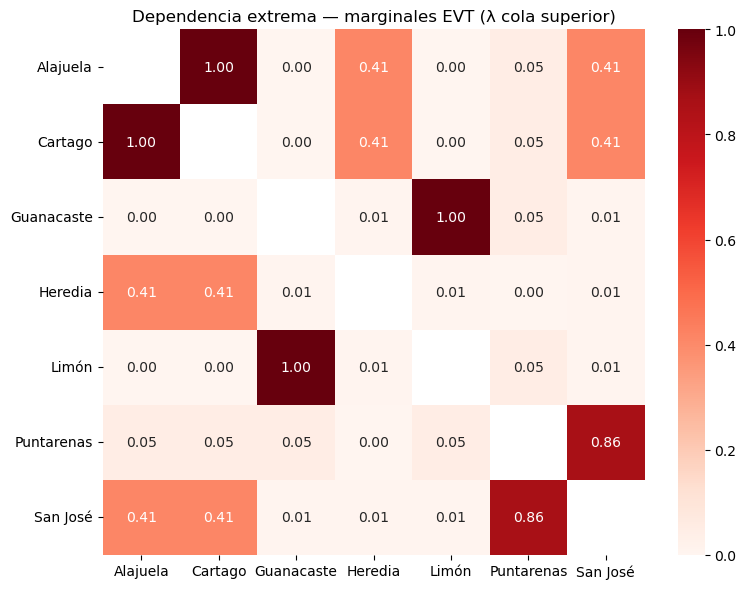

In [ ]:
piv_log = np.log(piv)

U_evt = construir_U_EVT(df, piv_log, carpeta_csv='../res/provincias', col_total='total', clip_eps=1e-6)

L_evt, F_evt = lambda_matrix(U_evt, metodo='auto', nu_fixed=5.0, tau_switch=0.05, n_min=3)

heatmap_lambda(L_evt, "Dependencia extrema — marginales EVT (λ cola superior)")

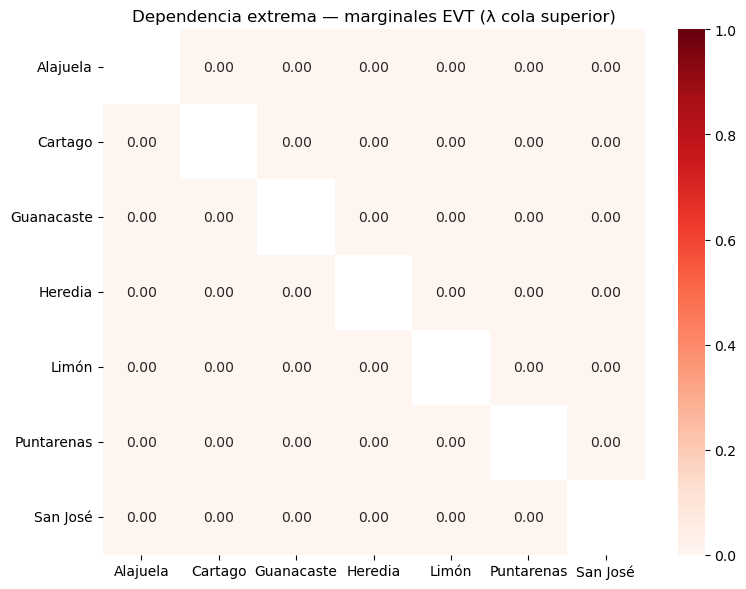

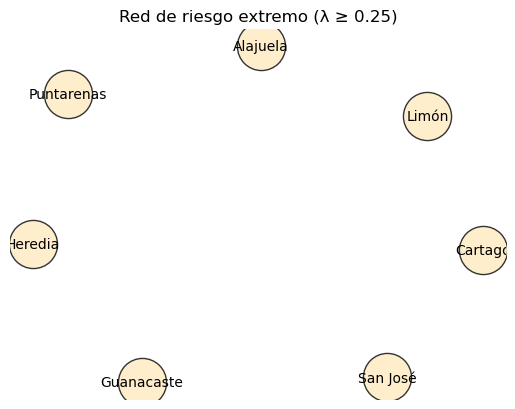

C:\Users\andre\AppData\Local\Temp\ipykernel_59532\4204720197.py:2: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(L.values)


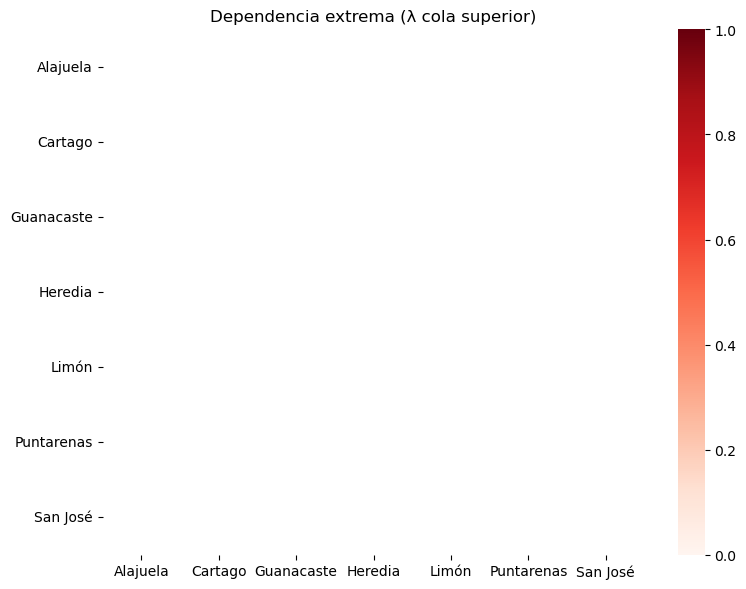

In [ ]:
# 1) Máximos anuales por provincia:
piv = max_anual_por_provincia(df, categoria=None, col_total='total', func_agregacion='max')

U_evt = construir_U_EVT(
    df, piv,
    carpeta_csv='../res/provincias',
    col_total='total',
    clip_eps=1e-6
)

# 3) Matriz de λ y familia ganadora por par:
L_evt, F_evt = lambda_matrix(
    U_evt,
    metodo='auto', nu_fixed=5.0, tau_switch=0.05, n_min=3
)
heatmap_lambda(L_evt, "Dependencia extrema — marginales EVT (λ cola superior)")
grafo_lambda(L_evt, umbral=0.25, titulo="Red de riesgo extremo (λ ≥ 0.25)")

L, F, U = dependencia_extrema(
    df,
    usar_evt=True,
    piv_index='categoria', piv_columns='provincia', piv_val='total', piv_agg='max',
    carpeta_csv='../res/provincias', col_total='total',
    metodo_lambda='auto', nu_fixed=5.0, tau_switch=0.05, n_min=3, plot=True
)


In [61]:
df_riesgos_prov = tabla_riesgo_provincias(df, carpeta='../res/csv_provincias')
df_riesgos_prov

FileNotFoundError: No se encontró ningún archivo tail para: Alajuela

In [62]:
df_riesgos_cat = tabla_riesgo_categorias(df, carpeta='../res/csv_categoria')
df_riesgos_cat

FileNotFoundError: No se encontró ningún archivo tail para: Geológico

## VaR y CVaR conjuntos

In [63]:
def Q_exc_gpd(alpha_exc, sigma, xi):

    alpha_exc = np.clip(alpha_exc, 1e-12, 1-1e-12)
    if abs(xi) < 1e-12:
        return - sigma * np.log1p(-alpha_exc)
    return (sigma/xi) * (np.exp(-xi*np.log1p(-alpha_exc)) - 1.0)

def Q_exc_pareto(alpha_exc, xm, k):
    alpha_exc = np.clip(alpha_exc, 1e-12, 1-1e-12)
    return xm * (np.exp(-(1.0/k)*np.log1p(-alpha_exc)) - 1.0)

def Q_exc_burr(alpha_exc, c, k, lam):
    alpha_exc = np.clip(alpha_exc, 1e-12, 1-1e-12)
    inner = np.exp(-(1.0/k)*np.log1p(-alpha_exc)) - 1.0
    inner = max(inner, 1e-18)
    return lam * (inner ** (1.0/c))

def Q_exc_lognormal(alpha_exc, mu, sig):
    z = norm.ppf(np.clip(alpha_exc, 1e-12, 1-1e-12))
    return float(np.exp(mu + sig * z))

def Q_total_hibrida(alpha, body_sample, u, p_u, model, params):

    alpha = float(np.clip(alpha, 1e-12, 1-1e-12))
    if alpha <= 1.0 - p_u:
        return float(np.quantile(body_sample, alpha, method='nearest'))

    alpha_exc = (alpha - (1.0 - p_u)) / p_u 
    m = str(model).lower()
    if m == 'gpd':
        sigma, xi = params
        return float(u + Q_exc_gpd(alpha_exc, sigma, xi))
    if m == 'pareto':
        xm, k = params
        return float(u + Q_exc_pareto(alpha_exc, xm, k))
    if m == 'burr':
        c, k, lam = params
        return float(u + Q_exc_burr(alpha_exc, c, k, lam))
    if m in ('ln_tail','lognormal','lognormal_tail'):
        mu, sig = params
        return float(u + Q_exc_lognormal(alpha_exc, mu, sig))
    raise ValueError(f"Modelo de cola no soportado en Q_total_hibrida: {model}")

In [64]:
def cargar_tail_prov_cat(prov, cat, carpeta_dual='csv_dual'):

    nombre = f"{str(prov).strip()}_{str(cat).strip()}".replace(" ","_")
    ruta = os.path.join(carpeta_dual, f"{nombre}_tail.csv")
    if not os.path.exists(ruta):
        return {'ok': False}
    dfp = pd.read_csv(ruta)
    if dfp.empty:
        return {'ok': False}
    mname = str(dfp.loc[0,'model_name']).strip()
    u     = float(dfp.loc[0,'u_opt'])
    p_u   = float(dfp.loc[0,'p_u'])
    cols  = [c for c in dfp.columns if 'param' in c.lower() or c.lower().startswith(mname.lower()+'_param')]
    cols  = sorted(cols, key=lambda s: int(''.join(filter(str.isdigit, s)) or 0))
    params = tuple(float(dfp.loc[0, c]) for c in cols)
    return {'ok': True, 'model': mname, 'u': u, 'p_u': p_u, 'params': params}

In [65]:
def pivote_maximos_por_categoria(df, categoria, col_total='total'):

    d = df[df['categoria'].eq(categoria)].copy()
    if d.empty:
        raise ValueError(f"No hay datos para categoria={categoria}")
    mx = (d.groupby(['ano','provincia'], as_index=False)
            .agg(max_total=(col_total,'max')))
    piv = mx.pivot(index='ano', columns='provincia', values='max_total').sort_index()
    return piv

def construir_U_por_categoria(df, categoria, carpeta_dual='csv_dual',
                              col_total='total', clip_eps=1e-6):
    piv = pivote_maximos_por_categoria(df, categoria, col_total=col_total)
    provincias = list(piv.columns)
    info = {}
    all_ok = True
    for prov in provincias:
        meta = cargar_tail_prov_cat(prov, categoria, carpeta_dual=carpeta_dual)
        info[prov] = meta
        all_ok = all_ok and meta.get('ok', False)

    U = pd.DataFrame(index=piv.index, columns=provincias, dtype=float)

    if all_ok:
        # EVT híbrida por provincia–categoría
        for prov in provincias:
            body = df[(df['provincia']==prov) & (df['categoria']==categoria)][col_total].dropna().values
            m,u,p_u,params = info[prov]['model'], info[prov]['u'], info[prov]['p_u'], info[prov]['params']
            U[prov] = piv[prov].apply(
                lambda x: np.nan if pd.isna(x)
                else F_total_hibrida(float(x), body, u, p_u, m, params)
            )
            U[prov] = U[prov].clip(clip_eps, 1.0 - clip_eps)
            info[prov]['marginal'] = 'evt_dual'
    else:
        # Fallback empírico por columna
        for prov in provincias:
            s = piv[prov].dropna()
            if s.empty:
                U[prov] = np.nan
                info[prov]['ok'] = False
                info[prov]['marginal'] = 'sin_datos'
                continue
            ranks = s.rank(method='average')/(len(s)+1.0)
            U.loc[s.index, prov] = ranks
            U[prov] = U[prov].clip(clip_eps, 1.0 - clip_eps)
            info[prov]['ok'] = info[prov].get('ok', False)
            info[prov]['marginal'] = 'fallback_empirico'
    return U, info


In [66]:
def corr_from_tau_pairwise(U: pd.DataFrame, min_pairs: int = 3, shrink: float = 1e-6):

    cols = list(U.columns)
    k = len(cols)
    R = np.eye(k)
    Npairs = pd.DataFrame(0, index=cols, columns=cols, dtype=int)

    for i in range(k):
        for j in range(i+1, k):
            a = U.iloc[:, i].to_numpy()
            b = U.iloc[:, j].to_numpy()
            m = np.isfinite(a) & np.isfinite(b)
            n_ij = int(m.sum())
            Npairs.iloc[i, j] = Npairs.iloc[j, i] = n_ij
            if n_ij < min_pairs:
                rho = 0.0
            else:
                tau, _ = kendalltau(a[m], b[m])
                rho = float(np.sin(np.pi * np.clip(tau if np.isfinite(tau) else 0.0, -1, 1) / 2.0))
            R[i, j] = R[j, i] = rho

    eigval, eigvec = np.linalg.eigh(R)
    eigval_clipped = np.clip(eigval, shrink, None)
    R_psd = eigvec @ np.diag(eigval_clipped) @ eigvec.T
    d = np.sqrt(np.clip(np.diag(R_psd), 1e-12, None))
    R_psd = (R_psd / d[:, None]) / d[None, :]
    return R_psd, cols, Npairs


def corr_from_tau(U: pd.DataFrame, shrink=1e-6):

    cols = U.columns
    k = len(cols)
    R = np.eye(k)
    for i in range(k):
        for j in range(i+1, k):
            tau, _ = kendalltau(U.iloc[:,i], U.iloc[:,j])
            rho = np.sin(np.pi * np.clip(tau, -1, 1) / 2.0) if np.isfinite(tau) else 0.0
            R[i,j] = R[j,i] = rho
    eigval, eigvec = np.linalg.eigh(R)
    eigval_clipped = np.clip(eigval, shrink, None)
    R_psd = (eigvec @ np.diag(eigval_clipped) @ eigvec.T)
    d = np.sqrt(np.clip(np.diag(R_psd), 1e-12, None))
    R_psd = (R_psd / d[:,None]) / d[None,:]
    return R_psd, list(cols)


def simulate_t_copula(R, nu, n_sims, random_state=None):

    rng = np.random.default_rng(random_state)
    k = R.shape[0]
    L = np.linalg.cholesky(R + 1e-12*np.eye(k))
    g = rng.standard_normal(size=(n_sims, k))
    z = g @ L.T
    w = rng.chisquare(df=nu, size=n_sims) / nu
    t_samples = z / np.sqrt(w[:,None])
    U = tdist.cdf(t_samples, df=nu)
    U = np.clip(U, 1e-12, 1-1e-12)
    return U  


def sampler_marginal_prov_cat(U_mat, df, categoria, provincias, info_marginal,
                              carpeta_dual='csv_dual', col_total='total'):

    n_sims, k = U_mat.shape
    X = np.zeros((n_sims, k), dtype=float)

    for j, prov in enumerate(provincias):
        meta = info_marginal[prov]
        dpc = df[(df['provincia']==prov) & (df['categoria']==categoria)][col_total].dropna().values
        if len(dpc) == 0:
            X[:,j] = 0.0
            continue

        if meta.get('marginal') == 'evt_dual':
            m,u,p_u,params = meta['model'], meta['u'], meta['p_u'], meta['params']
            alphas = U_mat[:,j]
            X[:,j] = np.array([Q_total_hibrida(float(a), dpc, u, p_u, m, params) for a in alphas], dtype=float)
        else:
            alphas = U_mat[:,j]
            X[:,j] = np.quantile(dpc, alphas, method='nearest')
    return X  

In [67]:
def var_cvar_portafolio_categoria(
    df, categoria,
    carpeta_dual='csv_dual',
    col_total='total',
    nu_copula=5.0,
    n_sims=200_000,
    alphas=(0.95, 0.99, 0.995),
    random_state=42,
    min_pairs=3,
    min_provincias=2
):
    # 1) U (sin dropna global) + info marginal
    U, info = construir_U_por_categoria(df, categoria, carpeta_dual=carpeta_dual, col_total=col_total)

    # quitar provincias sin ninguna observación en esta categoría
    keep = [c for c in U.columns if np.isfinite(U[c]).sum() >= min_pairs]
    if len(keep) < min_provincias:
        # Fallback: portafolio SIMPLE (suma nacional por año)
        out, S_sorted = var_cvar_portafolio_categoria_SIMPLE(df, categoria, col_total=col_total, alphas=alphas)
        out.update({'modo': 'simple_sum', 'detalle': 'datos insuficientes para cópula'})
        return out, None, S_sorted, ['_nacional_']

    U = U[keep]
    # 2) ρ por pares con solape
    R_psd, cols, Npairs = corr_from_tau_pairwise(U, min_pairs=min_pairs)

    if len(cols) < min_provincias:
        out, S_sorted = var_cvar_portafolio_categoria_SIMPLE(df, categoria, col_total=col_total, alphas=alphas)
        out.update({'modo': 'simple_sum', 'detalle': 'provincias válidas < min'})
        return out, None, S_sorted, ['_nacional_']

    # 3) Simulación t-cópula
    U_sim = simulate_t_copula(R_psd, nu=nu_copula, n_sims=n_sims, random_state=random_state)

    # 4) Mapear U → pérdidas por provincia
    X = sampler_marginal_prov_cat(U_sim, df, categoria, cols, info, carpeta_dual=carpeta_dual, col_total=col_total)

    # 5) Suma portafolio + VaR/TVaR
    S = X.sum(axis=1)
    S_sorted = np.sort(S)
    n = len(S_sorted)

    out = {
        'categoria': categoria,
        'modo': 'copula_t',
        'nu_copula': nu_copula,
        'n_sims': n_sims,
        'provincias_usadas': cols,
        'Npairs_min': int(np.min(Npairs.loc[cols, cols].replace(0, np.nan).min().min()))
    }
    for a in alphas:
        idx = max(0, int(np.floor(a*n)) - 1)
        var_a = float(S_sorted[idx])
        tail = S_sorted[idx+1:]
        tvar_a = float(tail.mean()) if tail.size > 0 else var_a
        out[f'VaR({a})'] = var_a
        out[f'TVaR({a})'] = tvar_a
    return out, pd.DataFrame(R_psd, index=cols, columns=cols), S_sorted, cols


In [68]:
'''
res, R_cat, S_cat, provs_cat = var_cvar_portafolio_categoria(
    df, 'INFRAESTRUCTURA',
    carpeta_dual='csv_dual', 
    nu_copula=5.0,
    n_sims=200_000,
    alphas=(0.95, 0.99, 0.995),
    random_state=123
)
pd.Series(res)
'''
tabla_port, R_por_cat = var_cvar_portafolio_todas_categorias(
    df, carpeta_dual='csv_dual', nu_copula=5.0, n_sims=200_000,
    alphas=(0.95, 0.99, 0.995), random_state=123
)
tabla_port


NameError: name 'var_cvar_portafolio_todas_categorias' is not defined

In [ ]:
def var_cvar_portafolio_categoria_SIMPLE(df, categoria,
                                         col_total='total',
                                         alphas=(0.95,0.99,0.995)):
    """
    VaR/TVaR nacional por categoría sin dependencia geográfica:
    Se suma la pérdida por provincia para cada año y se aplica EVT sobre S_C.
    """
    dfc = df[df['categoria']==categoria].copy()
    if dfc.empty:
        raise ValueError(f"No hay datos para categoria={categoria}")

    # Suma anual nacional
    S = (dfc.groupby('ano')[col_total].sum()).sort_index().values

    # VaR y TVaR empíricos (históricos) como mínimo
    out = {'categoria': categoria, 'n_obs': len(S)}
    for a in alphas:
        VaR = np.nanquantile(S, a)
        tail = S[S > VaR]
        TVaR = tail.mean() if len(tail)>0 else VaR
        out[f'VaR({a})'] = float(VaR)
        out[f'TVaR({a})'] = float(TVaR)
    return out, S


In [ ]:
res_inf, S_inf = var_cvar_portafolio_categoria_SIMPLE(df, 'INFRAESTRUCTURA')
pd.Series(res_inf)

categoria          INFRAESTRUCTURA
n_obs                           15
VaR(0.95)      135681718567.216843
TVaR(0.95)          239805887226.0
VaR(0.99)      218981053494.243317
TVaR(0.99)          239805887226.0
VaR(0.995)     229393470360.121643
TVaR(0.995)         239805887226.0
dtype: object

In [ ]:
var_cvar_portafolio_categoria(
    df, 'INFRAESTRUCTURA',
    carpeta_dual='csv_dual',
    col_total='total',
    nu_copula=5.0,
    n_sims=200_000,
    alphas=(0.95, 0.99, 0.995),
    random_state=42,
    min_pairs=3,
    min_provincias=2
)

({'categoria': 'INFRAESTRUCTURA',
  'modo': 'copula_t',
  'nu_copula': 5.0,
  'n_sims': 200000,
  'provincias_usadas': ['Alajuela',
   'Cartago',
   'Guanacaste',
   'Heredia',
   'Limón',
   'Puntarenas',
   'San José'],
  'Npairs_min': 2,
  'VaR(0.95)': 19575998790.0,
  'TVaR(0.95)': 31282842637.681564,
  'VaR(0.99)': 37951070829.0,
  'TVaR(0.99)': 51393933362.891045,
  'VaR(0.995)': 48769011147.0,
  'TVaR(0.995)': 60541859932.17911},
             Alajuela   Cartago  Guanacaste   Heredia     Limón  Puntarenas  \
 Alajuela    1.000000  0.479592    0.026950  0.214268  0.063403    0.268171   
 Cartago     0.479592  1.000000   -0.067724  0.414258  0.461440    0.575140   
 Guanacaste  0.026950 -0.067724    1.000000 -0.361157 -0.806282   -0.377530   
 Heredia     0.214268  0.414258   -0.361157  1.000000  0.667649   -0.274729   
 Limón       0.063403  0.461440   -0.806282  0.667649  1.000000    0.353287   
 Puntarenas  0.268171  0.575140   -0.377530 -0.274729  0.353287    1.000000   
 San J

In [ ]:
def tabla_riesgo_prov_cat_copula(
    df, 
    categorias=None,
    carpeta_dual='csv_dual',
    col_total='total',
    nu_copula=5.0,
    n_sims=200_000,
    alphas=(0.95, 0.99),
    random_state=42,
    min_pairs=3,
    min_provincias=2
):
    """
    Tabla global del tipo:
       provincia | categoria | VaR(α) | TVaR(α) | metodo | n_prov_cat | Npairs_min

    • Se usa copia t por (categoría) si hay datos suficientes
    • Fallback empírico por provincia–categoría si no hay cola dual
    """
    if categorias is None:
        categorias = sorted(df['categoria'].dropna().unique())

    resultados = []

    for cat in categorias:
        try:
            out, R_psd, S_sorted, provincias = var_cvar_portafolio_categoria(
                df, cat,
                carpeta_dual=carpeta_dual,
                col_total=col_total,
                nu_copula=nu_copula,
                n_sims=n_sims,
                alphas=alphas,
                random_state=random_state,
                min_pairs=min_pairs,
                min_provincias=min_provincias
            )
        except Exception as e:
            print(f"Categoría {cat}: fallback simple ({e})")
            out = None

        # ----------------------------------------------------
        # Si no hubo cópula, usar fallback empírico por prov-cat
        # ----------------------------------------------------
        if (out is None) or (out.get('modo') != 'copula_t'):
            tmp = tabla_riesgo_provincia_categoria(
                df[df['categoria']==cat],
                carpeta_dual=carpeta_dual,
                col_total=col_total,
                alphas=alphas
            )
            tmp['categoria'] = cat
            tmp['metodo_final'] = tmp['metodo'] + " + fallback_port"
            resultados.append(tmp)
            continue

        # ----------------------------------------------------
        # Mapeo de simulaciones por provincia para VaR provincial sistémico
        # ----------------------------------------------------
        U, info = construir_U_por_categoria(df, cat, carpeta_dual, col_total)
        provincias_cat = out['provincias_usadas']
        U_sim = simulate_t_copula(R_psd.values, nu_copula, n_sims, random_state)
        X = sampler_marginal_prov_cat(U_sim, df, cat, provincias_cat, info, carpeta_dual, col_total)

        for j, prov in enumerate(provincias_cat):
            dpc = df[(df['provincia']==prov) & (df['categoria']==cat)][col_total].dropna().values
            if len(dpc) == 0: 
                continue

            row = {'provincia': prov, 'categoria': cat,
                   'metodo_final': 'copula_t_EVT'}
            for a in alphas:
                s = np.sort(X[:,j])
                n = len(s)
                idx = max(0, int(np.floor(a*n))-1)
                var_a = float(s[idx])
                tail = s[idx+1:]
                tvar_a = float(tail.mean()) if tail.size>0 else var_a
                row[f'VaR({a})'] = var_a
                row[f'TVaR({a})'] = tvar_a

            row['n_obs'] = len(dpc)
            row['Npairs_min'] = out.get('Npairs_min', None)
            resultados.append(pd.DataFrame([row]))

    return pd.concat(resultados, ignore_index=True)


In [ ]:
tabla_riesgo_prov_cat_copula(
    df, 
    categorias=None,
    carpeta_dual='csv_dual',
    col_total='total',
    nu_copula=5.0,
    n_sims=200_000,
    alphas=(0.95, 0.99),
    random_state=42,
    min_pairs=3,
    min_provincias=2
)

,provincia,categoria,metodo_final,VaR(0.95),TVaR(0.95),VaR(0.99),TVaR(0.99),n_obs,Npairs_min
0,Alajuela,HÍDRICO,copula_t_EVT,1.022260e+09,1.492799e+09,2.310000e+09,2.310000e+09,33,1
1,Cartago,HÍDRICO,copula_t_EVT,5.000000e+08,5.654101e+08,5.910371e+08,5.910371e+08,15,1
2,Guanacaste,HÍDRICO,copula_t_EVT,1.500000e+09,1.955800e+09,2.082663e+09,2.082663e+09,39,1
3,Heredia,HÍDRICO,copula_t_EVT,1.454000e+09,1.454000e+09,1.454000e+09,1.454000e+09,8,1
4,Limón,HÍDRICO,copula_t_EVT,3.222328e+09,3.469866e+09,3.828000e+09,3.828000e+09,26,1
5,Puntarenas,HÍDRICO,copula_t_EVT,2.550000e+09,4.332760e+09,5.305000e+09,5.305000e+09,47,1
6,San José,HÍDRICO,copula_t_EVT,2.527000e+09,6.350710e+09,3.138125e+09,1.996952e+10,54,1
7,Alajuela,INFRAESTRUCTURA,copula_t_EVT,2.933728e+09,5.380331e+09,6.570477e+09,8.532285e+09,178,2
8,Cartago,INFRAESTRUCTURA,copula_t_EVT,8.524669e+09,1.084545e+10,1.256012e+10,1.292285e+10,72,2
9,Guanacaste,INFRAESTRUCTURA,copula_t_EVT,1.757748e+09,3.301803e+09,5.469354e+09,6.158765e+09,194,2


In [ ]:
def var_cvar_joint_prov_cat(
    df, 
    carpeta_prov='csv_provincia',
    carpeta_cat='csv_categoria',
    col_total='total',
    nu_copula=5.0,
    n_sims=200000,
    alphas=(0.95, 0.99),
    random_state=42
):
    resultados = []
    provincias = sorted(df['provincia'].unique())
    categorias = sorted(df['categoria'].unique())

    for C in categorias:
        # Simulación dependiente por categoría usando cópula t sobre provincias
        U_dep, info_dep = construir_U_por_categoria(df, C, carpeta_dual=carpeta_prov, col_total=col_total)
        R, cols, _ = corr_from_tau_pairwise(U_dep)
        U_sim = simulate_t_copula(R, nu=nu_copula, n_sims=n_sims, random_state=random_state)

        for j, prov in enumerate(cols):
            dprov = df[df['provincia']==prov][col_total].dropna().values
            dcat  = df[df['categoria']==C][col_total].dropna().values
            if len(dprov)==0 or len(dcat)==0:
                continue

            # Inversa usando SOLO modelo provincial
            metaP = cargar_tail_params_provincia(prov, carpeta_prov)
            mP,uP,pP,parP = metaP['model'], metaP['u'], metaP['p_u'], metaP['params']
            Xprov_sim = np.array([Q_total_hibrida(a, dprov, uP, pP, mP, parP)
                                  for a in U_sim[:,j]], dtype=float)

            # Ajuste categórico (escala por severidad típica de la categoría)
            esc = np.mean(dcat) / np.mean(dprov)
            X_joint = Xprov_sim * esc

            # VaR / CVaR
            for a in alphas:
                s = np.sort(X_joint)
                n = len(s)
                idx = max(0, int(np.floor(a*n))-1)
                var_a = float(s[idx])
                tail = s[idx+1:]
                tvar_a = float(tail.mean()) if len(tail)>0 else var_a

                resultados.append({
                    'provincia': prov,
                    'categoria': C,
                    'VaR': var_a,
                    'TVaR': tvar_a,
                    'alpha': a
                })

    return pd.DataFrame(resultados)


In [ ]:
conjunto = var_cvar_joint_prov_cat(
    df, 
    carpeta_prov='../res/csv_provincias',
    carpeta_cat='../res/csv_categoria',
    col_total='total',
    nu_copula=5.0,
    n_sims=200000,
    alphas=(0.95, 0.99),
    random_state=42
)

C:\Users\andre\AppData\Local\Temp\ipykernel_9960\3553669498.py:6: RuntimeWarning: overflow encountered in exp
  return (sigma/xi) * (np.exp(-xi*np.log1p(-alpha_exc)) - 1.0)
C:\Users\andre\AppData\Local\Temp\ipykernel_9960\3553669498.py:6: RuntimeWarning: overflow encountered in exp
  return (sigma/xi) * (np.exp(-xi*np.log1p(-alpha_exc)) - 1.0)
C:\Users\andre\AppData\Local\Temp\ipykernel_9960\3553669498.py:6: RuntimeWarning: overflow encountered in exp
  return (sigma/xi) * (np.exp(-xi*np.log1p(-alpha_exc)) - 1.0)
C:\Users\andre\AppData\Local\Temp\ipykernel_9960\3553669498.py:6: RuntimeWarning: overflow encountered in exp
  return (sigma/xi) * (np.exp(-xi*np.log1p(-alpha_exc)) - 1.0)
C:\Users\andre\AppData\Local\Temp\ipykernel_9960\3553669498.py:6: RuntimeWarning: overflow encountered in exp
  return (sigma/xi) * (np.exp(-xi*np.log1p(-alpha_exc)) - 1.0)
C:\Users\andre\AppData\Local\Temp\ipykernel_9960\3553669498.py:6: RuntimeWarning: overflow encountered in exp
  return (sigma/xi) * (np

In [ ]:
conjunto

,provincia,categoria,VaR,TVaR,alpha
0,Alajuela,HÍDRICO,1.502177e+09,2.352085e+10,0.95
1,Alajuela,HÍDRICO,8.392520e+09,1.045250e+11,0.99
2,Cartago,HÍDRICO,1.527000e+09,4.644988e+09,0.95
3,Cartago,HÍDRICO,4.728440e+09,1.328583e+10,0.99
4,Guanacaste,HÍDRICO,2.049544e+09,8.826700e+09,0.95
...,...,...,...,...,...
65,Limón,SOCIAL,1.359272e+09,1.552325e+09,0.99
66,Puntarenas,SOCIAL,9.324088e+08,9.324924e+08,0.95
67,Puntarenas,SOCIAL,9.324223e+08,9.328187e+08,0.99
68,San José,SOCIAL,1.607789e+09,5.217170e+09,0.95


In [ ]:

df_clean = conjunto.replace([np.inf, -np.inf], np.nan).dropna()

# 2) Pivotear para una fila por combinación (provincia, categoría)
df_pivot = (
    df_clean
    .pivot_table(
        index=['provincia','categoria'],
        columns='alpha',
        values=['VaR','TVaR']
    )
)

# 3) Renombro columnas para resultado limpio
df_pivot.columns = [
    f"{metric}({alpha:.2f})"
    for metric, alpha in df_pivot.columns
]

df_pivot = df_pivot.reset_index()

# 4) Ordenar decreciente por VaR(0.95) y luego VaR(0.99)
df_final = (
    df_pivot
    .sort_values(by=['VaR(0.95)','VaR(0.99)'], ascending=[False, False])
    .reset_index(drop=True)
)

df_final


,provincia,categoria,TVaR(0.95),TVaR(0.99),VaR(0.95),VaR(0.99)
0,San José,OTROS,2.410999e+10,7.201691e+10,7.670594e+09,2.326808e+10
1,Guanacaste,OTROS,3.179107e+10,1.189762e+11,6.588310e+09,1.943079e+10
2,Cartago,OTROS,1.477173e+10,4.136375e+10,4.977234e+09,1.565129e+10
3,Alajuela,OTROS,7.556493e+10,3.358052e+11,4.826012e+09,2.696247e+10
4,Puntarenas,OTROS,4.453710e+09,4.455380e+09,4.453282e+09,4.453348e+09
5,San José,INFRAESTRUCTURA,1.305946e+10,4.148005e+10,3.810759e+09,1.121111e+10
6,Limón,OTROS,5.005060e+09,7.326852e+09,3.590089e+09,6.492023e+09
7,San José,PRODUCTIVO,1.038806e+10,3.129000e+10,3.290369e+09,9.842695e+09
8,Guanacaste,INFRAESTRUCTURA,1.468588e+10,5.363837e+10,3.273918e+09,9.633496e+09
9,Guanacaste,PRODUCTIVO,1.221326e+10,4.377290e+10,2.844101e+09,8.342180e+09


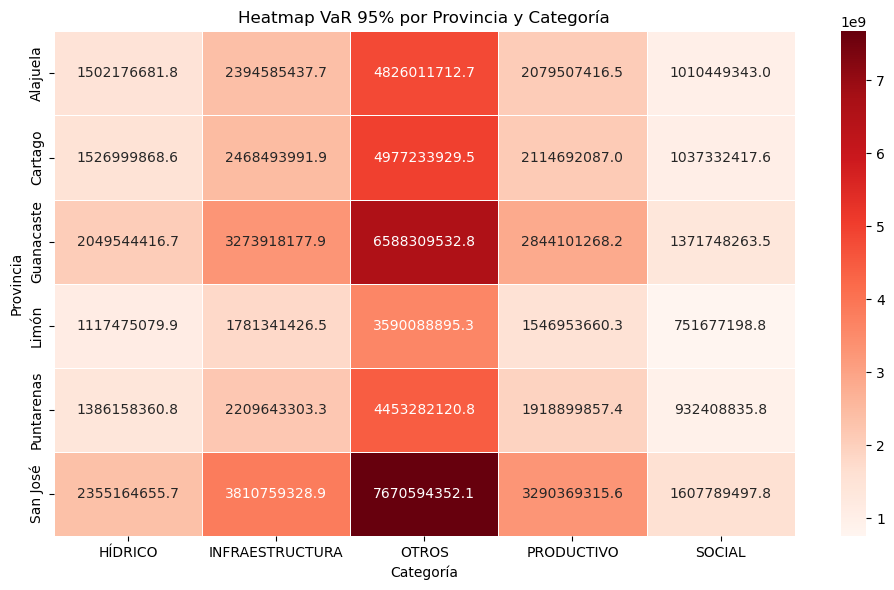

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot para heatmap VaR(0.95)
mat_95 = df_final.pivot(index='provincia', columns='categoria', values='VaR(0.95)')

plt.figure(figsize=(10,6))
sns.heatmap(mat_95, annot=True, fmt=".1f", cmap="Reds", linewidths=0.5)
plt.title("Heatmap VaR 95% por Provincia y Categoría")
plt.xlabel("Categoría")
plt.ylabel("Provincia")
plt.tight_layout()
plt.show()


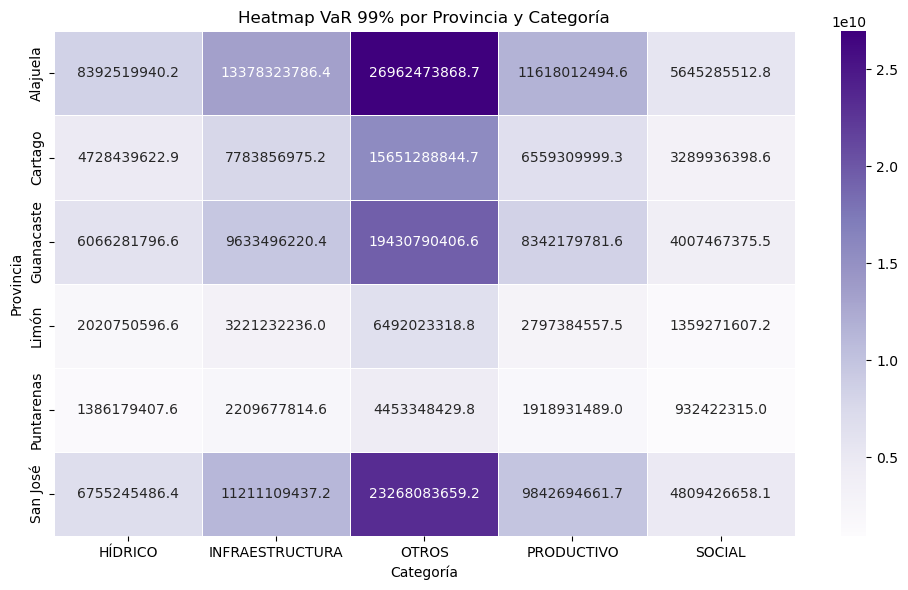

In [ ]:
# Pivot para heatmap VaR(0.99)
mat_99 = df_final.pivot(index='provincia', columns='categoria', values='VaR(0.99)')

plt.figure(figsize=(10,6))
sns.heatmap(mat_99, annot=True, fmt=".1f", cmap="Purples", linewidths=0.5)
plt.title("Heatmap VaR 99% por Provincia y Categoría")
plt.xlabel("Categoría")
plt.ylabel("Provincia")
plt.tight_layout()
plt.show()
